In [35]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../pytools')
import d2l

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [36]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)
    ])

In [37]:
X = tf.random.uniform((1,28,28,1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:', X.shape)

Conv2D output shape: (1, 28, 28, 6)
AveragePooling2D output shape: (1, 14, 14, 6)
Conv2D output shape: (1, 10, 10, 16)
AveragePooling2D output shape: (1, 5, 5, 16)
Flatten output shape: (1, 400)
Dense output shape: (1, 120)
Dense output shape: (1, 84)
Dense output shape: (1, 10)


In [38]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [39]:
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    """一个以可视化的训练进展的回调"""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()

    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

In [40]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizier = tf.keras.optimizers.SGD(learning_rate=lr)
        net = net_fn()
        net.compile(optimizer=optimizier, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs, device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net


loss 0.406, train acc 0.849, test acc 0.835
63144.4 examples/sec on /GPU:0


<Sequential name=sequential_13, built=True>

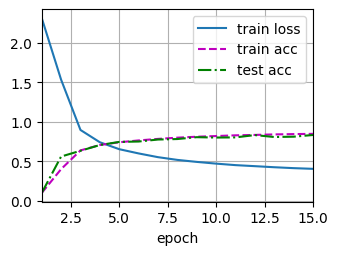

In [41]:
lr, num_epochs = 0.9, 15
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())